In [2]:
# IMPORTS
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Load GeoPandas Data

In [44]:
gdf = geopandas.read_file('./data/Project/tl_2018_us_state.shp')

# Drop Hawaii, Virign Islands, Northern Mariana Islands, Guam, Alaska, American Samoa, and Puerto Rico
# so that geopandas.plot() can correctly display the continental US
gdf = gdf.drop(labels=[31,34,35,36,40,41,49], axis='index')

gdf.head(1)

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266474513,489028543,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39...."


### Load and Append EIA.gov Datasets

In [45]:
# Dictionary of CSVs
csv_files = {'net_coal_consumption': './data/Project/Total_coal_consumption_for_all_sectors_all_states_pipe_format.csv',
             'net_wind_generation' : './data/Project/Wind_Net_generation_for_all_sectors_map_pipe_format.csv',
             'fossil_fuel_stocks'  : './data/Project/Fossil-fuel_stocks_for_electricity_generation_pipe_format.csv',
             'average_retail_price': './data/Project/Average_retail_price_of_electricity_pipe_format.csv',
             'revenue_from_elec'   : './data/Project/Revenue_from_retail_sales_of_electricity_pipe_format.csv'}

net_coal_consumption, net_wind_generation, fossil_fuel_stocks, average_retail_price, revenue_from_elec = \
[pd.read_csv(csv_files[dataset], lineterminator='|', skiprows=1) for dataset in csv_files]

In [46]:
# Verify read integrity
net_coal_consumption.shape, net_wind_generation.shape, fossil_fuel_stocks.shape, average_retail_price.shape, revenue_from_elec.shape

((51, 218), (51, 218), (51, 134), (51, 134), (51, 218))

In [47]:
# Clean DataFrames
list_of_dfs = [net_coal_consumption, net_wind_generation, fossil_fuel_stocks, average_retail_price, revenue_from_elec]

[dataframe.rename(columns={'\n':'state'}, inplace=True) for dataframe in list_of_dfs]

# No parameter to strip values in place, so I must use a for loop
for dataframe in list_of_dfs:
    dataframe['state'] = dataframe['state'].str.strip('"US-\n')

net_coal_consumption.head(1)

,state,200101,200102,200103,200104,200105,200106,200107,200108,200109,...,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901
0,AK,58.615,77.587,76.351,48.312,51.169,47.746,76.143,96.767,88.44,...,61.676,66.211,67.9,69.165,84.167,98.32,NaN,103.786,84.947,99.698


In [48]:
# Find the most recent column with the fewest NaN values for each DataFrame
# Here I have to make a tradeoff between the two, so I'll handpick the column
[dataframe.isna().sum()
                 .sort_index(ascending=False)
                 .sort_values(0).head(10) 
 for dataframe in list_of_dfs]

[state     0
 200711    3
 200710    3
 200709    3
 200708    3
 200707    3
 200706    3
 200705    3
 200704    3
 200703    3
 dtype: int64, state      0
 201612    10
 201702    10
 201703    10
 201704    10
 201705    10
 201706    10
 201707    10
 201708    10
 201709    10
 dtype: int64, state     0
 201008    5
 201007    5
 201006    5
 201005    5
 201004    5
 201003    5
 201002    5
 201001    5
 200911    5
 dtype: int64, state     0
 201101    0
 201102    0
 201103    0
 201104    0
 201105    0
 201106    0
 201107    0
 201108    0
 201109    0
 dtype: int64, state     0
 200708    0
 200707    0
 200706    0
 200705    0
 200704    0
 200703    0
 200702    0
 200701    0
 200612    0
 dtype: int64]

### Merge GeoDataFrame and Energy DataFrames

In [51]:
# Geoframe must on the left to retain geoframe type instead of dataframe type
columns = ['201810','201712','201008','201601','201901']

for col, dataset in zip(columns, list_of_dfs):
    gdf = gdf.merge(dataset[col], left_on='STUSPS', right_on=dataset['state'], how='left')

gdf = gdf.rename(columns={'201810':'net_coal_consumption_201810',
                          '201712':'net_wind_generation_201712',
                          '201008':'fossil_fuel_stocks_201008',
                          '201601':'average_retail_price_201601',
                          '201901':'revenue_from_elec_201901'})

gdf.head(1)

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,net_coal_consumption_201810,net_wind_generation_201712,fossil_fuel_stocks_201008,average_retail_price_201601,revenue_from_elec_201901
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266474513,489028543,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39....",1785.234,211.01101,5704.38,8.88,259.76419


### Plot Choropleth Visualizations

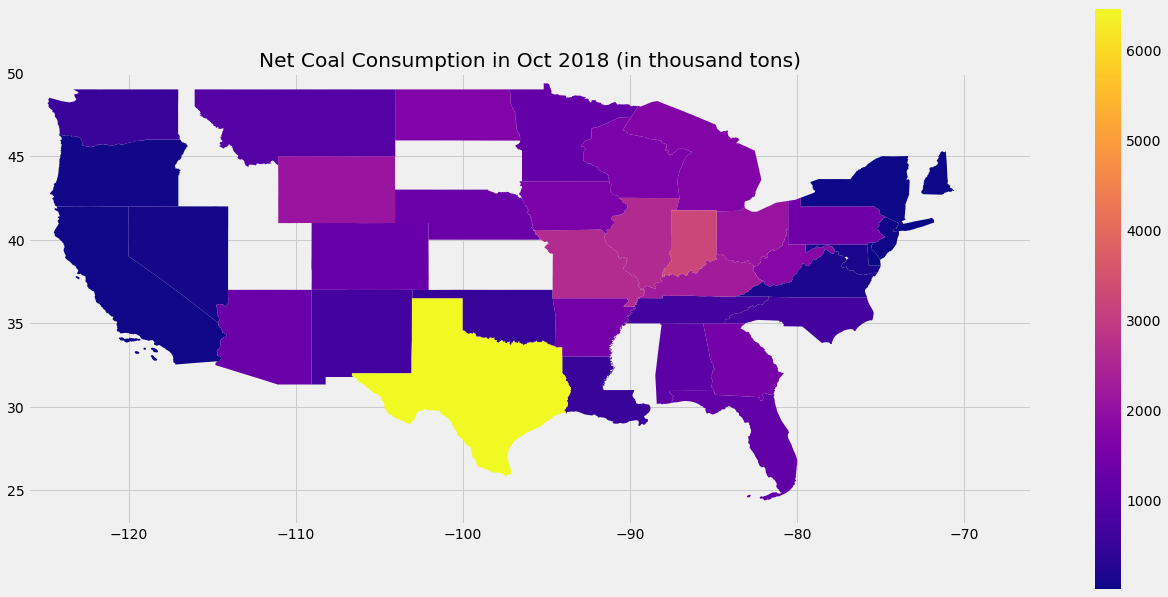

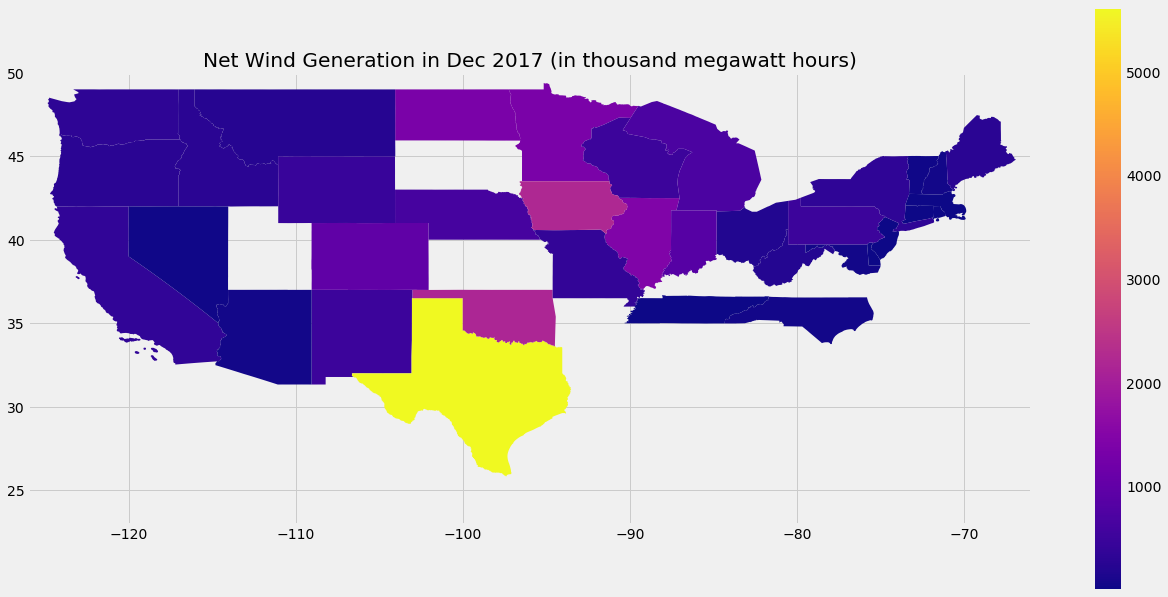

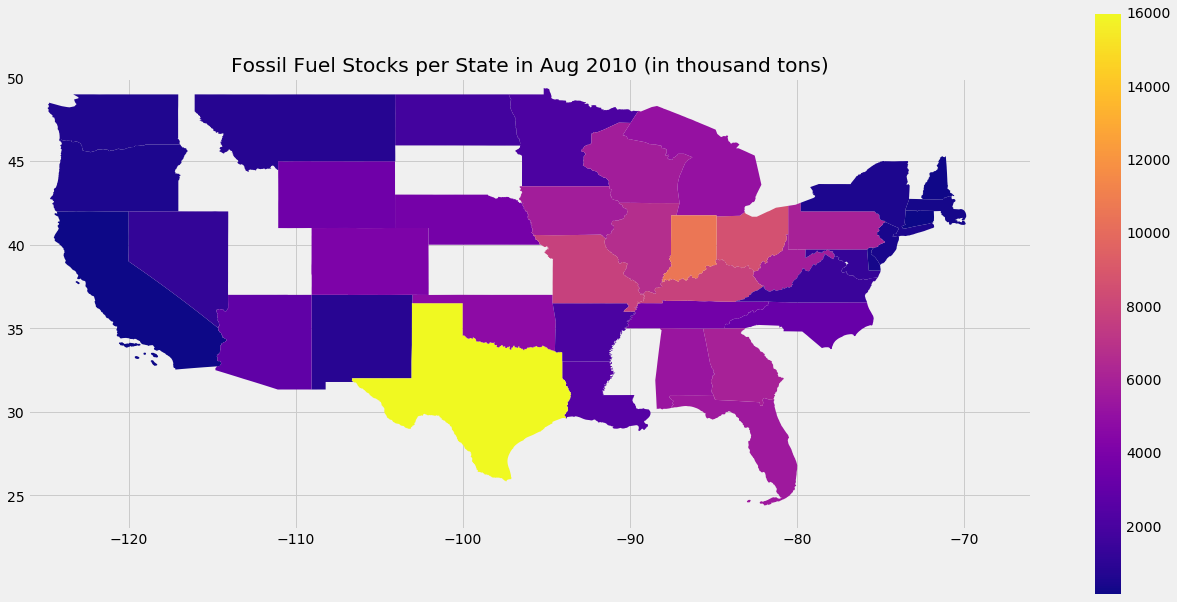

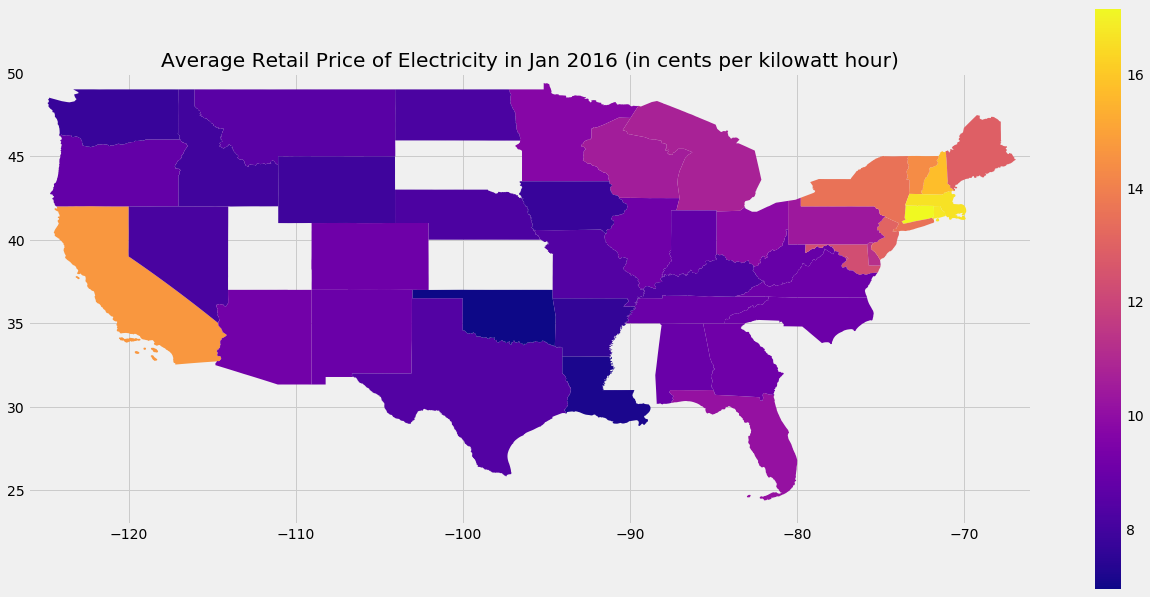

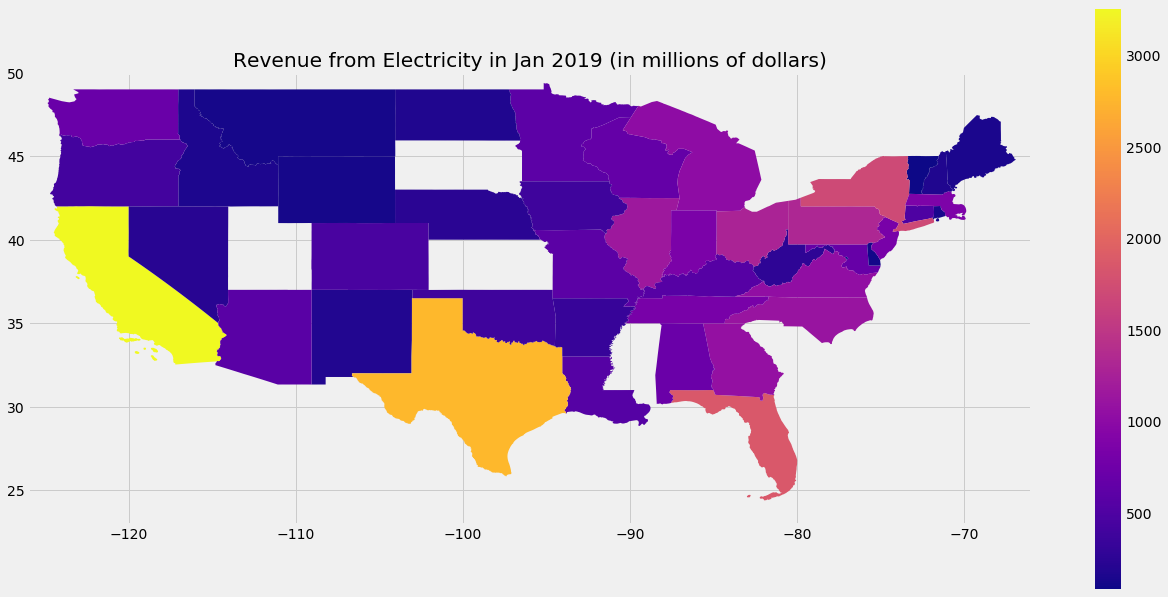

In [56]:
titles = ['Net Coal Consumption in Oct 2018 (in thousand tons)',
          'Net Wind Generation in Dec 2017 (in thousand megawatt hours)',
          'Fossil Fuel Stocks per State in Aug 2010 (in thousand tons)',
          'Average Retail Price of Electricity in Jan 2016 (in cents per kilowatt hour)',
          'Revenue from Electricity in Jan 2019 (in millions of dollars)']

for column, title in zip(gdf.loc[:, 'net_coal_consumption_201810':'revenue_from_elec_201901'], titles):
    plt.style.use('fivethirtyeight');
    fig, ax = plt.subplots(figsize = (20,10))
    
    plt.title(title)
    ax.set_xlim([-126,-66])
    ax.set_ylim([23,50])
    gdf.dropna(subset=[column]) \
       .plot(column=column, ax=ax, cmap='plasma', vmin=gdf[column].min(), vmax=gdf[column].max(), legend=True);

### Plot Bar Graphs of Choropleth Data

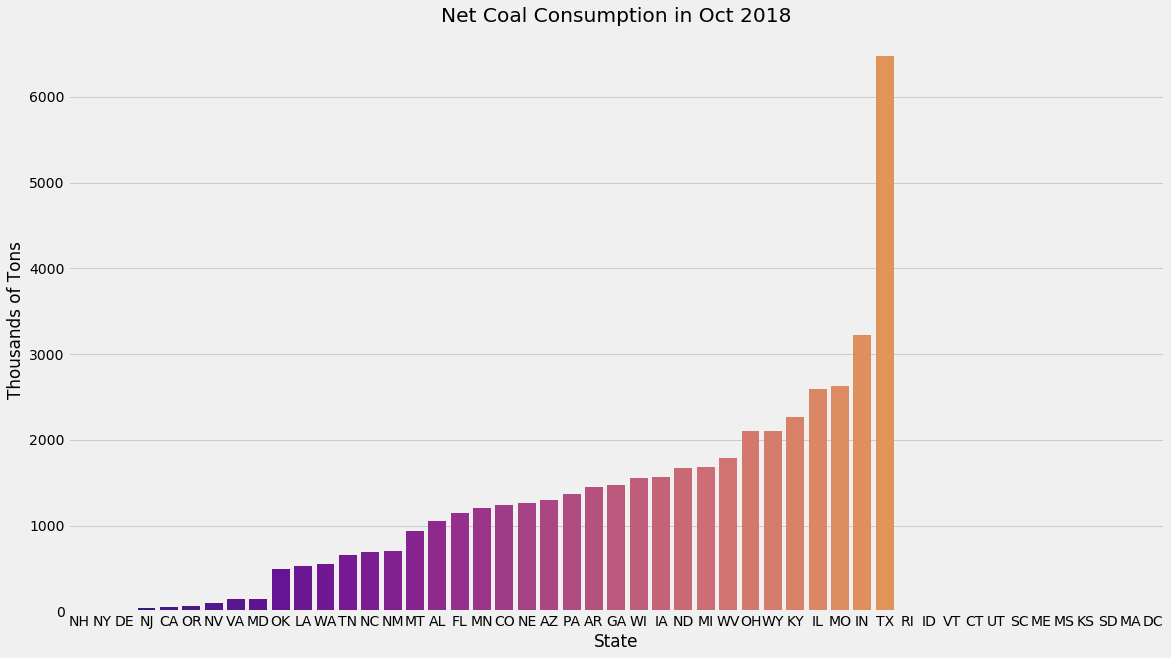

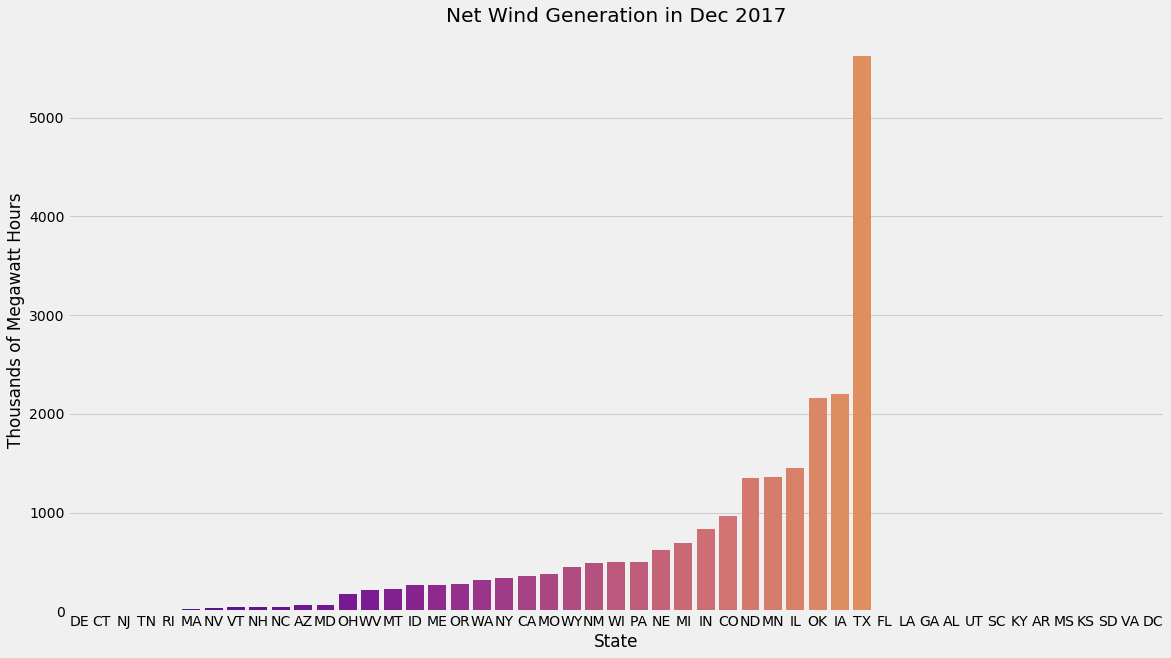

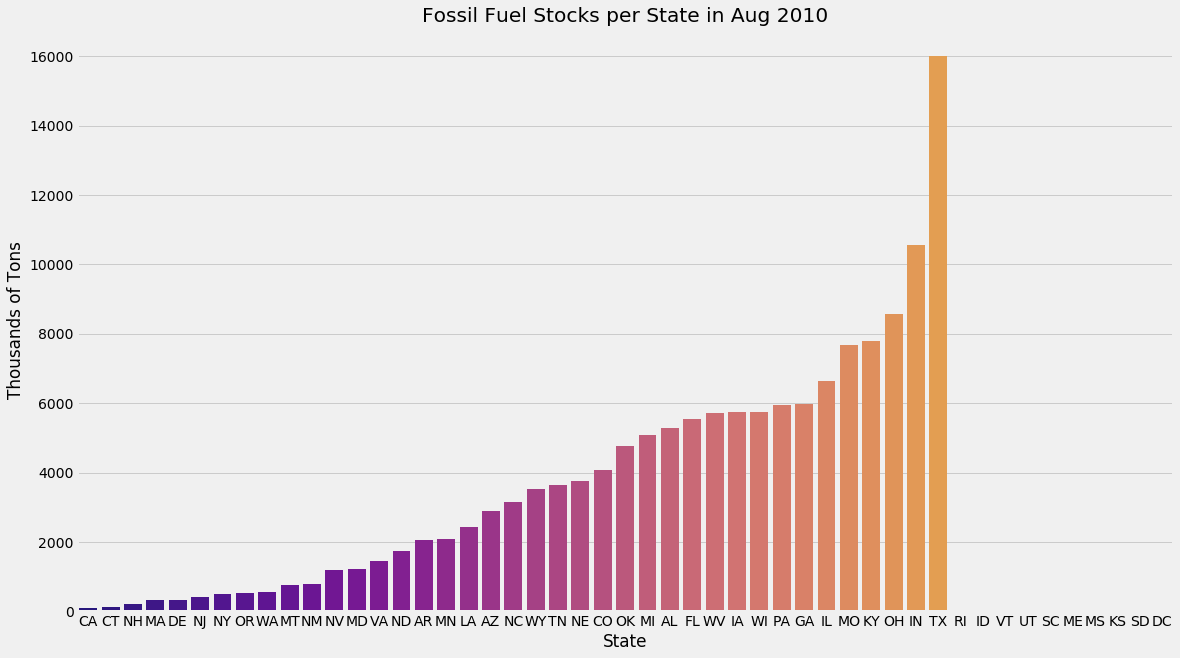

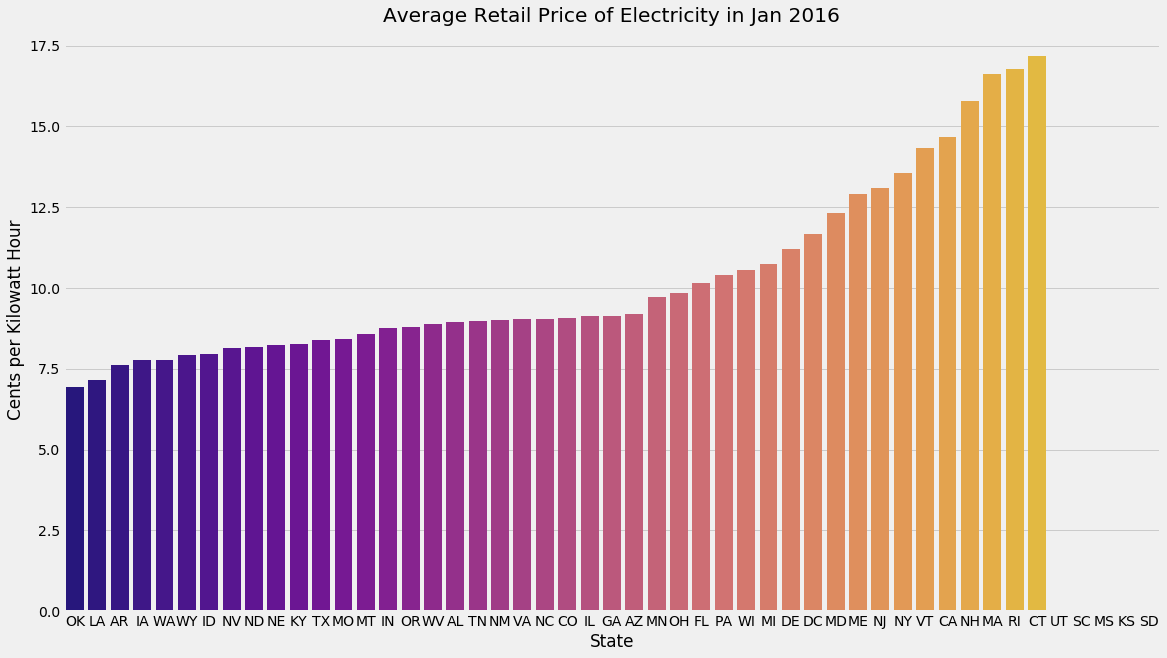

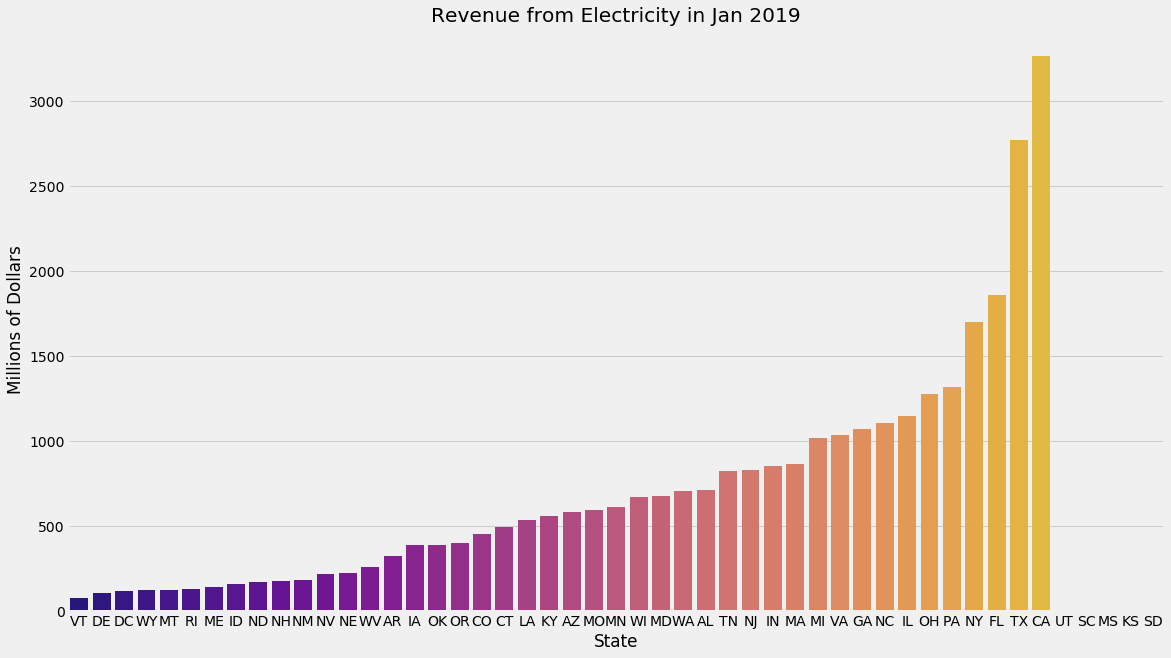

In [61]:
titles = ['Net Coal Consumption in Oct 2018',
          'Net Wind Generation in Dec 2017',
          'Fossil Fuel Stocks per State in Aug 2010',
          'Average Retail Price of Electricity in Jan 2016',
          'Revenue from Electricity in Jan 2019']

unit_labels = ['Thousands of Tons', 'Thousands of Megawatt Hours', 
               'Thousands of Tons', 'Cents per Kilowatt Hour', 'Millions of Dollars']

for column, title, unit_label in zip(gdf.loc[:, 'net_coal_consumption_201810':'revenue_from_elec_201901'], titles, unit_labels):
    plt.figure(figsize=(17.5,10))
    plt.style.use('fivethirtyeight');
    sns.barplot(x='STUSPS', y=column, data=gdf.sort_values(column), palette='plasma')
    plt.title(title)
    plt.xlabel('State')
    plt.ylabel(unit_label);